# <a style='color:blue'>Segmentez des clients d'un site e-commerce (Notebook 2: essais)

- <a href="#C1">1: Préparation des données</a>
    - <a href="#C11">1.1 Imports</a>
    - <a href="#C12">1.2 Sélection des features RFM</a>
    - <a href="#C13">1.3 Standardisation des données</a>

- <a href="#C2">2: Essais de modèles de clustering avec RFM</a>
    - <a href="#C21">2.1 K-means</a>
        - <a href="#C211">2.1.1 Choix du nombre de clusters</a>
        - <a href="#C212">2.1.2 Caractérisation des clusters</a>
        - <a href="#C213">2.1.3 Visualisation 3D des clusters</a>
    - <a href="#C22">2.2 Clustering hiérarchique</a>
        - <a href="#C221">2.2.1 Choix du nombre de clusters</a>
        - <a href="#C222">2.2.2 Visualisation 3D des clusters</a>
    - <a href="#C23">2.3 DBSCAN</a>
        - <a href="#C231">2.3.1 Entrainement du modèle</a>
        - <a href="#C232">2.3.2 Visualisation 3D des clusters</a>       
    - <a href="#C24">2.4 Comparaison des résultats et choix du modèle</a>
        
- <a href="#C3">3: Essai du k-means avec RFM + review_score</a>
    - <a href="#C31">3.1 Sélection des features RFM + review_score</a>
    - <a href="#C32">3.2 Standardisation des données</a>
    - <a href="#C33">3.3 Choix du nombre de clusters</a>
    - <a href="#C34">3.4 Caractérisation des clusters</a>

# <a name="C1">Partie 1: Préparation des données</a>

# <a name="C11">1.1 Imports</a>

In [1]:
# librairies Pandas et Numpy
import pandas as pd
import numpy as np

# clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

# preprocessing
from sklearn import preprocessing

# metrics
from sklearn import metrics

# visualisation
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes

# import fichier CSV
data=pd.read_csv('data_after_feat_eng.csv')
data.set_index('customer_unique_id', inplace=True)

# <a name="C12">1.2 Sélection des features RFM</a>

In [2]:
dataRFM=data.loc[:,['récence','fréquence','montant']]
dataRFM

,récence,fréquence,montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,8,1,4.962145
0000b849f77a49e4a4ce2b2a4ca5be3f,8,1,3.338967
0000f46a3911fa3c0805444483337064,1,1,4.468434
0000f6ccb0745a6a4b88665a16c9f078,3,1,3.798182
0004aac84e0df4da2b147fca70cf8255,4,1,5.287711
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,1,7.634540
fffea47cd6d3cc0a88bd621562a9d061,5,1,4.449452
ffff371b4d645b6ecea244b27531430a,1,1,4.731450


# <a name="C13">1.3 Standardisation des données</a>

In [3]:
# Transformation du dataframe dataRFM en array
X=dataRFM.values

# Standardisation avec Standard Scaler
std_scale = preprocessing.StandardScaler().fit(X)
X_norm= std_scale.transform(X)

# <a name="C2">Partie 2: Essais de modèles de clustering avec RFM</a>

# <a name="C21">2.1 K-means</a>

# <a name="C211">2.1.1 Choix du nombre de clusters</a>

**- Coefficient de silhouette**

Déterminons l'**homogénéité et la séparation des clusters** en calculant le coefficient de silhouette pour plusieurs valeurs de K

Utilisons **k-means++** pour empêcher l'initialisation aléatoirement du k-means

In [4]:
silhouettes=[]
for clust_num in range(2,9):
    cls=KMeans(n_clusters=clust_num, n_init=1, init='k-means++', random_state=0)
    cls.fit(X_norm)
    silh=metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)
    

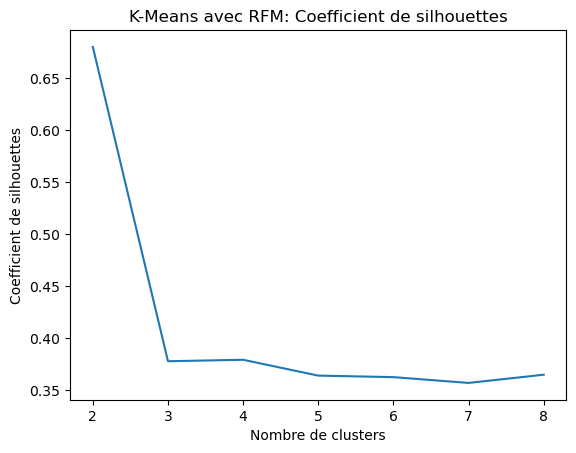

In [5]:
plt.plot(range(2,9), silhouettes)
plt.title('K-Means avec RFM: Coefficient de silhouettes')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouettes')
plt.show()

- Le coefficient de silhouettes est le plus élevé pour **K=2 mais ce n'est pas pertinent du point de vue métier**

- Le coefficient de silhouettes varie peu pour des valeurs de K allant de 3 à 8

- En complément, utilisons la méthode du coude pour déterminer la valeur optimale de K

**- Méthode du coude**

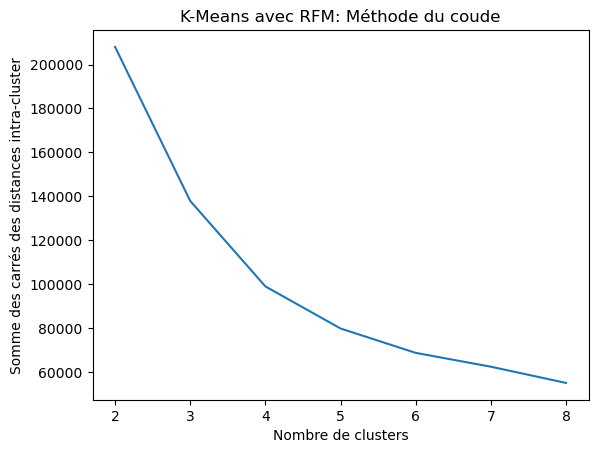

In [6]:
sse = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=1, init='k-means++', random_state=0).fit(X_norm)
    sse.append(kmeans.inertia_)
plt.plot(range(2, 9), sse)
plt.title('K-Means avec RFM: Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-cluster')
plt.show()

En combinant les résultats du coefficient de silhouette et la méthode du coude, le **nombre de cluster optimal est K=5**

# <a name="C212">2.1.2 Caractérisation des clusters</a>

**- Entrainement du k-means pour K=5**

In [7]:
kmeans5 = KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=0).fit(X_norm)

**- Fonction qui affiche un radar chart**

In [8]:
def radar_factory(num_vars, frame='circle'):
    """
    Fonction qui créé un radar chart avec 'num_vars' axes
    :param num_vars: Nombres d'axes/features à afficher
    :return: theta
    """
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    theta += np.pi/2

    def draw_poly_frame(self, x0, y0, r):
        verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_frame(self, x0, y0, r):
        return plt.Circle((x0, y0), r)

    frame_dict = {'polygon': draw_poly_frame, 'circle': draw_circle_frame}
    if frame not in frame_dict:
        raise ValueError(f'Unknown value for `frame`: {frame}. Allowed values are {list(frame_dict.keys())}.')
    frame_func = frame_dict[frame]

    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1
        draw_frame = frame_func

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

    register_projection(RadarAxes)
    return theta

**- Caractérisation des clusters avec un radar chart**

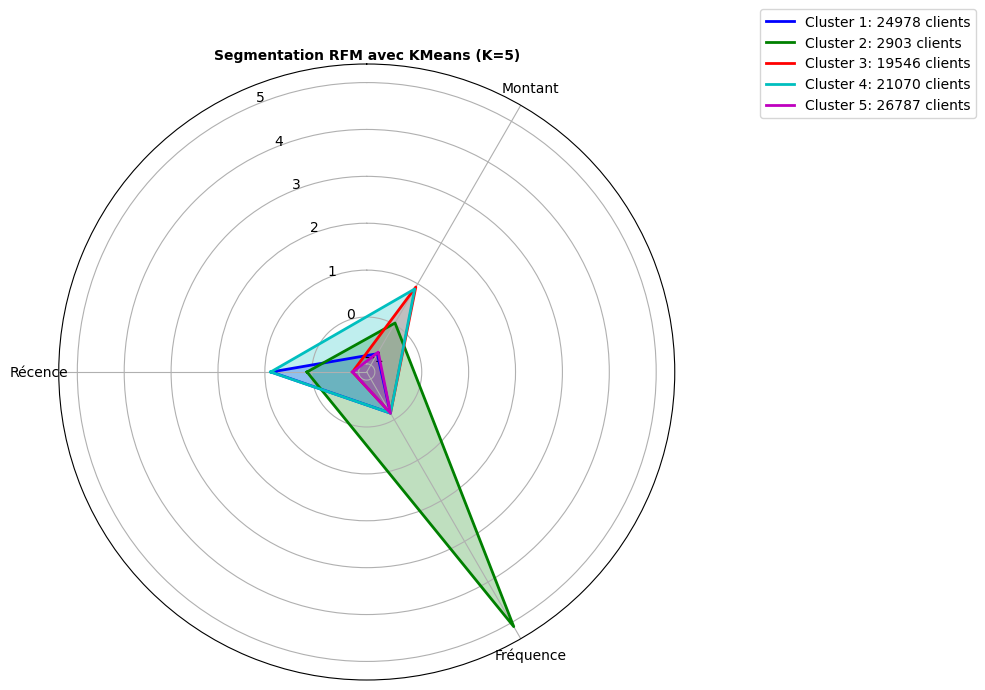

In [9]:
theta = radar_factory(3, frame='circle')
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='radar'))

ax.set_title('Segmentation RFM avec KMeans (K=5)', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Calcul du nombre de clients de chaque cluster avec counts
unique, counts = np.unique(kmeans5.labels_, return_counts=True)

for i in range(5):
    ax.plot(theta, kmeans5.cluster_centers_[i], color=colors[i], linewidth=2, label=f'Cluster {i+1}: {counts[i]} clients')
    ax.fill(theta, kmeans5.cluster_centers_[i], facecolor=colors[i], alpha=0.25)
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))

# Draw one axe per variable + add labels
categories=["Récence","Fréquence","Montant"]
plt.xticks(theta, categories)

plt.show()

Caractérisation des 5 clusters:

- Cluster 1: LOYAUX: Montant faible, achat récent 

- Cluster 2: FIDELES: Plusieurs commandes, montant moyen, assez récent
    
- Cluster 3: A REACTIVER: Montant élevé, achat pas récent

- Cluster 4: CHAMPIONS: Montant élevé, achat très récent

- Cluster 5: PERDUS: Montant faible, achat pas récent

# <a name="C213">2.1.3 Visualisation 3D des clusters</a>

<function matplotlib.pyplot.show(close=None, block=None)>

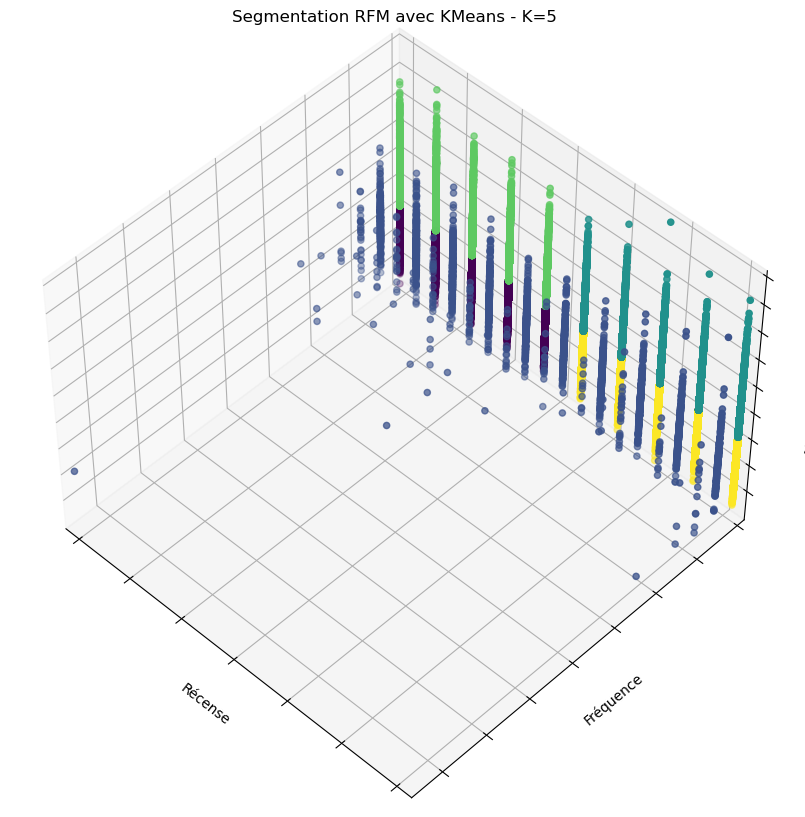

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)

ax.scatter(X_norm[:, 0], X_norm[:, 1], X_norm[:, 2], c=kmeans5.labels_)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlim(X_norm[:, 0].min(), X_norm[:, 0].max())
ax.set_ylim(X_norm[:, 1].min(), X_norm[:, 1].max())
ax.set_zlim(X_norm[:, 2].min(), X_norm[:, 2].max())

ax.set_xlabel("Récense")
ax.set_ylabel("Fréquence")
ax.set_zlabel("Montant moyen")
title="Segmentation RFM avec KMeans - K=5"
ax.set_title(title)
plt.show

# <a name="C22">2.2 Clustering hierarchique</a>

Le clustering hiérarchique demande un temps de calcul et des ressources mémoires élevés. 

Avec nos ressources disponibles, nous pouvons réussir à entrainer le modèle sur seulement 40% du dataset. 

In [45]:
# Sélection aléatoire de 40% des lignes
mask = np.random.choice([True, False], size=X_norm.shape[0], p=[0.4, 0.6])
Xhalf_norm = X_norm[mask]

# <a name="C221">2.2.1 Choix du nombre de clusters</a>

**- Coefficient de silhouette**

In [12]:
silhouettes=[]
for clust_num in range(2,9):
    agg=AgglomerativeClustering(n_clusters=clust_num)
    agg.fit(Xhalf_norm)
    silh=metrics.silhouette_score(Xhalf_norm, agg.labels_)
    silhouettes.append(silh)

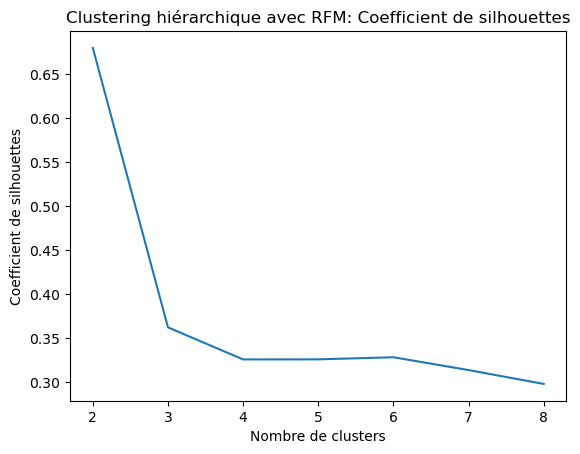

In [13]:
plt.plot(range(2,9), silhouettes)
plt.title('Clustering hiérarchique avec RFM: Coefficient de silhouettes')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouettes')
plt.show()

- Le coefficient de silhouettes est le plus élevé pour K=2 mais ce n'est pas pertinent du point de vue métier

- Le coefficient de silhouettes varie peu pour des valeurs de K allant de 3 à 8

- En complément, utilisons un dendogramme pour déterminer la valeur optimale de K

**- Dendrogrammme**

Le dendogramme permet de visualiser le résultat du clustering agglomératif.

Visualisons uniquement la partie supérieure du dendrogramme, pour éviter d'avoir à représenter tous les points

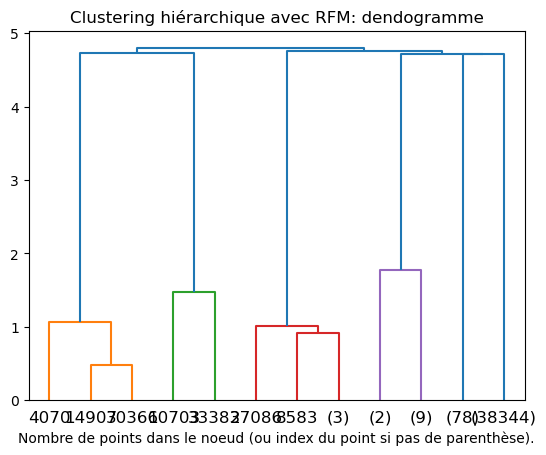

In [60]:
Z=linkage(Xhalf_norm)
dendrogram(Z, truncate_mode='level', p=3)
plt.xlabel("Nombre de points dans le noeud (ou index du point si pas de parenthèse).")
plt.title("Clustering hiérarchique avec RFM: dendogramme")
plt.show()

D'après le dendogramme ci-dessus, la distance entre les clusters est la plus élévée avec 6 clusters.
En combinant les résultats du coefficient de silhouette et du dendogramme, le **nombre de cluster optimal est K=6**

# <a name="C222">2.2.2 Visualisation 3D des clusters</a>

<function matplotlib.pyplot.show(close=None, block=None)>

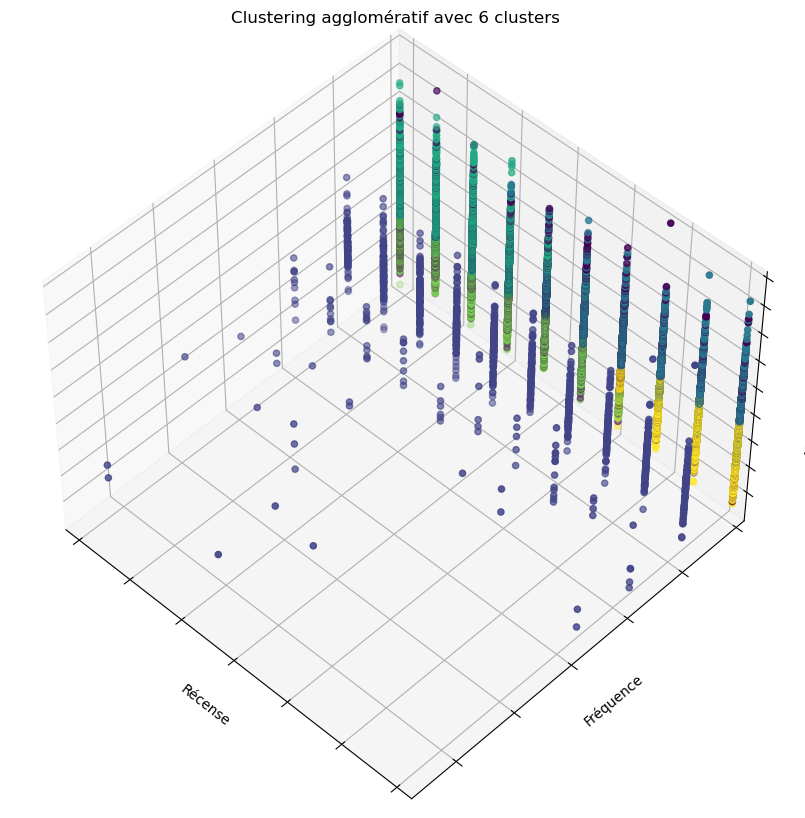

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)
agg=AgglomerativeClustering(n_clusters=6)
agg.fit(Xhalf_norm)

ax.scatter(Xhalf_norm[:, 0], Xhalf_norm[:, 1], Xhalf_norm[:, 2], c=agg.labels_)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlim(Xhalf_norm[:, 0].min(), Xhalf_norm[:, 0].max())
ax.set_ylim(Xhalf_norm[:, 1].min(), Xhalf_norm[:, 1].max())
ax.set_zlim(Xhalf_norm[:, 2].min(), Xhalf_norm[:, 2].max())

ax.set_xlabel("Récense")
ax.set_ylabel("Fréquence")
ax.set_zlabel("Montant moyen")
title="Clustering agglomératif avec 6 clusters"
ax.set_title(title)
plt.show

**- Taille des clusters**

In [56]:
agg.labels_
np.unique(agg.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [58]:
print("Cluster 1:", list(agg.labels_).count(0), "clients")
print("Cluster 2:", list(agg.labels_).count(1), "clients")
print("Cluster 3:", list(agg.labels_).count(2), "clients")
print("Cluster 4:", list(agg.labels_).count(3), "clients")
print("Cluster 5:", list(agg.labels_).count(4), "clients")
print("Cluster 6:", list(agg.labels_).count(5), "clients")

Cluster 1: 6503 clients
Cluster 2: 1185 clients
Cluster 3: 8266 clients
Cluster 4: 8083 clients
Cluster 5: 6762 clients
Cluster 6: 7644 clients


# <a name="C23">2.3 DBSCAN</a>

A la différence des 2 modèles de clustering testés précedemment, DBSCAN ne demande pas de prédéfinir le nombre de clusters

# <a name="C231">2.3.1 Entrainement du modèle</a>

In [16]:
dbscan = DBSCAN()
dbscan.fit(X_norm)

DBSCAN()

In [17]:
labels=dbscan.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3], dtype=int64)

Le label -1 correspond a du bruit. **DBSCAN a identifié 4 clusters**

In [18]:
# Nombre de clusters dans labels, en ignorant le bruit
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Nombre de clusters: %d" % n_clusters_)
print("Nombre de points correspondant à du bruit: %d" % n_noise_)

Nombre de clusters: 4
Nombre de points correspondant à du bruit: 48


In [19]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_norm, labels):.3f}")

Silhouette Coefficient: 0.651


# <a name="C232">2.3.2 Visualisation 3D des clusters</a>

<function matplotlib.pyplot.show(close=None, block=None)>

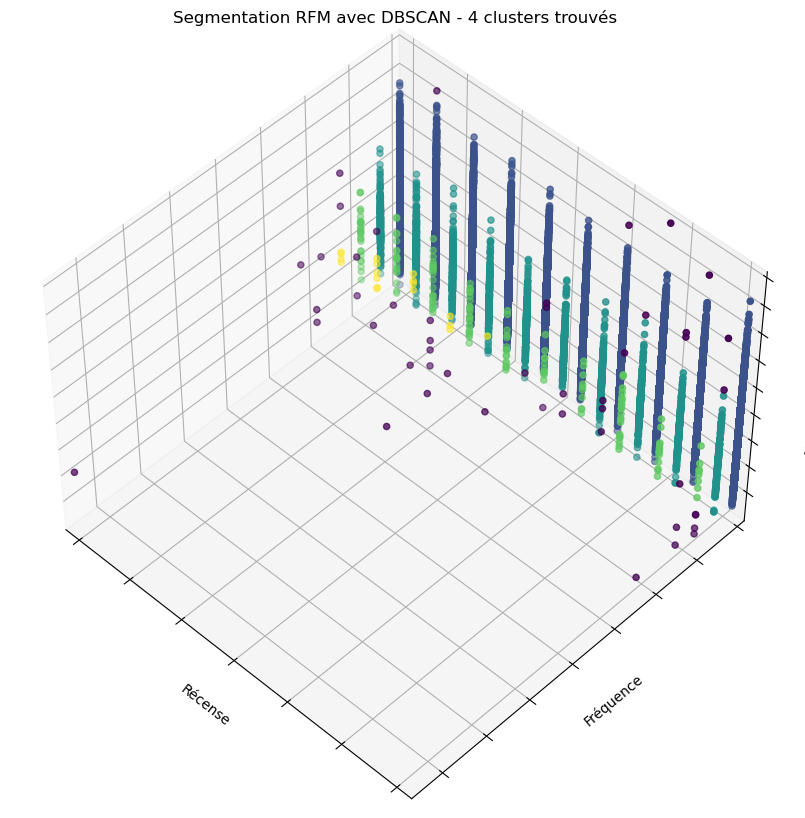

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)
ax.scatter(X_norm[:, 0], X_norm[:, 1], X_norm[:, 2], c=dbscan.labels_)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# Ajustement des limites des axes
ax.set_xlim(X_norm[:, 0].min(), X_norm[:, 0].max())
ax.set_ylim(X_norm[:, 1].min(), X_norm[:, 1].max())
ax.set_zlim(X_norm[:, 2].min(), X_norm[:, 2].max())

ax.set_xlabel("Récense")
ax.set_ylabel("Fréquence")
ax.set_zlabel("Montant moyen")
title="Segmentation RFM avec DBSCAN - 4 clusters trouvés"
ax.set_title(title)
plt.show

# <a name="C233">2.3.3 Caractérisation des clusters</a>

**- Taille des clusters**

In [21]:
print("Cluster 1:", list(labels).count(0), "clients")
print("Cluster 2:", list(labels).count(1), "clients")
print("Cluster 3:", list(labels).count(2), "clients")
print("Cluster 4:", list(labels).count(3), "clients")

Cluster 1: 92377 clients
Cluster 2: 2664 clients
Cluster 3: 177 clients
Cluster 4: 18 clients


- **Le cluster 1 contient 97% des clients: ceux qui ont effectué une seule commande**
    
- Le résultat du DBSCAN n'est pas acceptable du point de vue métier

# <a name="C24">2.4 Comparaison des résultats et choix du modèle</a>

Synthèse comparative des résultats des modèles de clustering

In [62]:
res = [['K-Means', "Silhouette + coude", "5 clusters", "0.37", "ClusterMin=2903, ClusterMax=26787", "AUCUN"],
        ['Clustering hiérarchique', "Silhouette + dendogramme", "6 clusters", "0.33", "ClusterMin=1185, ClusterMax=8266", " Ressources mémoires élevés (40% du dataset)"],
        ['DBSCAN', "Ne peut pas être prédéfini", "4 clusters", "0.65", "ClusterMin=18, ClusterMax=92377", "97% des clients dans le même cluster"]]
        
res = pd.DataFrame(res, columns=['Modèle de clustering', 'Recherche nb de clusters', 'Nb optimal de clusters', 'Coefficient de silhouette', 'Taille des partitions','Inconvénient majeur'])
res

,Modèle de clustering,Recherche nb de clusters,Nb optimal de clusters,Coefficient de silhouette,Taille des partitions,Inconvénient majeur
0,K-Means,Silhouette + coude,5 clusters,0.37,"ClusterMin=2903, ClusterMax=26787",AUCUN
1,Clustering hiérarchique,Silhouette + dendogramme,6 clusters,0.33,"ClusterMin=1185, ClusterMax=8266",Ressources mémoires élevés (40% du dataset)
2,DBSCAN,Ne peut pas être prédéfini,4 clusters,0.65,"ClusterMin=18, ClusterMax=92377",97% des clients dans le même cluster


**Choisissons le k-means** car:
- k-means ne présente pas d'inconvénient majeur contrairement au clustering hiérarchique et au DBSCAN
- le coefficient de silhouette atteint 0.33, ce qui est acceptable pour de la segmentation de clients
- les 5 clusters trouvés par k-means sont caractérisables

# <a name="C3">Partie 3: Essai du k-means avec RFM + review_score </a>

# <a name="C31">3.1 Sélection des features RFM + review_score</a>

In [23]:
# Sélection des données RFM + review_score
X=data.loc[:,['récence','fréquence','montant','review_score']]

# <a name="C32">3.2 Standardisation des données</a>

In [24]:
#Transformation en array
X=X.values 

# Standardisation avec Standard Scaler
std_scale = preprocessing.StandardScaler().fit(X)
X_norm= std_scale.transform(X)

# <a name="C33">3.3 Choix du nombre de clusters</a>

**- Coefficient de silhouette**

Déterminons l'**homogénéité et la séparation des clusters** en calculant le coefficient de silhouette pour plusieurs valeurs de K

Utilisons **k-means++** pour empêcher l'initialisation aléatoirement du k-means

In [25]:
silhouettes=[]
for clust_num in range(3,8):
    cls=KMeans(n_clusters=clust_num, n_init=1, init='k-means++', random_state=0)
    cls.fit(X_norm)
    silh=metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)

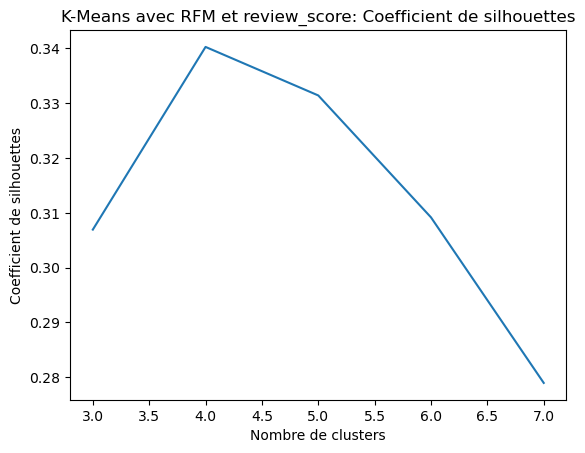

In [26]:
# Affichage du coefficient de silhouettes
plt.plot(range(3,8), silhouettes)
plt.title('K-Means avec RFM et review_score: Coefficient de silhouettes')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouettes')
plt.show()

- Le coefficient de silhouettes est le plus élevé pour K=4 et K=5

- En complément, utilisons la méthode du coude pour déterminer la valeur optimale de K

**- Méthode du coude**

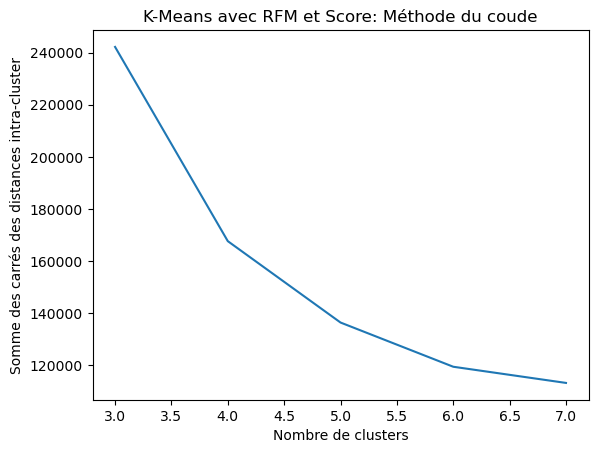

In [27]:
sse = []
for k in range(3, 8):
    kmeans = KMeans(n_clusters=k, n_init=1, init='k-means++', random_state=0).fit(X_norm)
    sse.append(kmeans.inertia_)
plt.plot(range(3, 8), sse)
plt.title('K-Means avec RFM et Score: Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-cluster')
plt.show()

En combinant les résultats du coefficient de silhouette et la méthode du coude, le **nombre de cluster optimal est K=5**

# <a name="C34">3.4 Caractérisation des clusters</a>

**- Entrainement du k-means pour K=5**

In [28]:
kmeans5RFMS = KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=0)
kmeans5RFMS.fit(X_norm)

KMeans(n_clusters=5, n_init=1, random_state=0)

**- Caractérisation des clusters avec un radar chart**

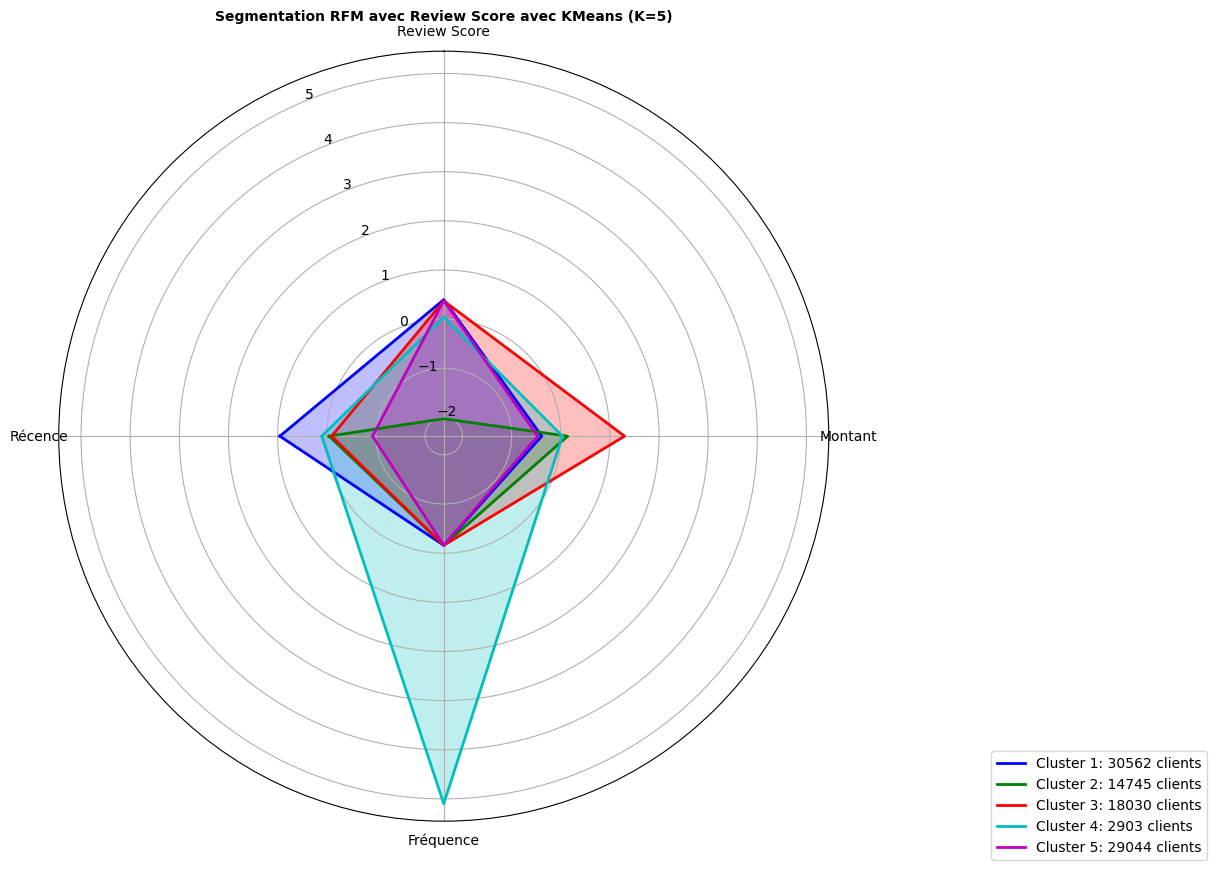

In [29]:
theta = radar_factory(4, frame='circle')
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))

ax.set_title('Segmentation RFM avec Review Score avec KMeans (K=5)', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
colors = ['b', 'g', 'r', 'c', 'm']
unique, counts = np.unique(kmeans5RFMS.labels_, return_counts=True) # pour afficher le nombre de clients de chaque cluster avec counts

for i in range(5):
    ax.plot(theta, kmeans5RFMS.cluster_centers_[i], color=colors[i], linewidth=2, label=f'Cluster {i+1}: {counts[i]} clients')
    ax.fill(theta, kmeans5RFMS.cluster_centers_[i], facecolor=colors[i], alpha=0.25)
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 0.1))

# Draw one axe per variable + add labels
categories=["Récence","Fréquence","Montant", "Review Score"]
plt.xticks(theta, categories)

plt.show()

**Caractérisation des 5 clusters:**

- Cluster 1: LOYAUX: Achat récent, montant faible, très satisfaits
- Cluster 2: MECONTENTS: achat assez récent, montant moyen, pas satisfaits
- Cluster 3: CHAMPIONS: Achat assez récent, montant élevé, très satisfait
- Cluster 4: FIDELES: Plusieurs commandes, dernier achat assez récent, montant moyen, satisfait
- Cluster 5: A REACTIVER:  Achat pas récent, montant faible, très satifaits